# Method 9 - Best Ideas High Minus Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
low_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

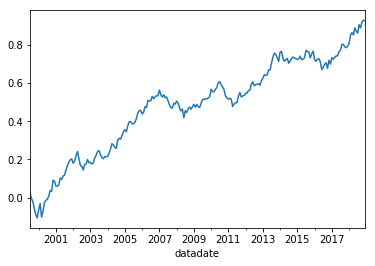

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.105470
2000-12-31    0.215212
2001-12-31    0.106394
2002-12-31   -0.016757
2003-12-31    0.026118
2004-12-31    0.108328
2005-12-31    0.082254
2006-12-31    0.052936
2007-12-31   -0.028299
2008-12-31   -0.009624
2009-12-31    0.035835
2010-12-31   -0.004222
2011-12-31    0.008829
2012-12-31    0.050437
2013-12-31    0.062145
2014-12-31    0.008688
2015-12-31    0.022670
2016-12-31   -0.038403
2017-12-31    0.055055
2018-12-31    0.073546
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     8.784
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-06
Time:                        20:37:30   Log-Likelihood:                 662.75
No. Observations:                 234   AIC:                            -1315.
Df Residuals:                     229   BIC:                            -1298.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.349      0.001       0.001       0.005
mktrf         -0.1188      0.027     -4.423      0.000      -0.172      -0.066
me             0.1079      0.031      3.452      0.001       0.046       0.169
ia             0.0536      0.047      1.130      0.260      -0.040       0.147
roe           -0.1169      0.041     -2.875      0.004      -0.197      -0.037
==============================================================================
Omnibus:                        9.241   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               18.211
Skew:                          -0.025   Prob(JB):                     0.000111
Kurtosis:                       4.366   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     3.765
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00549
Time:                        20:37:30   Log-Likelihood:                 662.75
No. Observations:                 234   AIC:                            -1315.
Df Residuals:                     229   BIC:                            -1298.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.154      0.002       0.001       0.005
mktrf         -0.1188      0.044     -2.719      0.007      -0.204      -0.033
me             0.1079      0.031      3.453      0.001       0.047       0.169
ia             0.0536      0.065      0.830      0.407      -0.073       0.180
roe           -0.1169      0.066     -1.775      0.076      -0.246       0.012
==============================================================================
Omnibus:                        9.241   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               18.211
Skew:                          -0.025   Prob(JB):                     0.000111
Kurtosis:                       4.366   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     4.843
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000910
Time:                        20:37:30   Log-Likelihood:                 662.75
No. Observations:                 234   AIC:                            -1315.
Df Residuals:                     229   BIC:                            -1298.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.268      0.001       0.001       0.005
mktrf         -0.1188      0.040     -2.950      0.003      -0.198      -0.040
me             0.1079      0.033      3.266      0.001       0.043       0.173
ia             0.0536      0.073      0.739      0.460      -0.089       0.196
roe           -0.1169      0.057     -2.035      0.042      -0.229      -0.004
==============================================================================
Omnibus:                        9.241   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               18.211
Skew:                          -0.025   Prob(JB):                     0.000111
Kurtosis:                       4.366   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     6.701
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.59e-06
Time:                        20:37:30   Log-Likelihood:                 662.09
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     228   BIC:                            -1291.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.367      0.001       0.001       0.005
mktrf         -0.1039      0.027     -3.842      0.000      -0.157      -0.051
smb            0.0711      0.036      1.991      0.048       0.001       0.141
hml            0.0460      0.042      1.093      0.275      -0.037       0.129
rmw           -0.1414      0.048     -2.972      0.003      -0.235      -0.048
cma            0.0787      0.060      1.301      0.195      -0.040       0.198
==============================================================================
Omnibus:                        8.478   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               15.868
Skew:                           0.005   Prob(JB):                     0.000358
Kurtosis:                       4.276   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     2.400
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0381
Time:                        20:37:30   Log-Likelihood:                 662.09
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     228   BIC:                            -1291.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.318      0.001       0.001       0.005
mktrf         -0.1039      0.038     -2.766      0.006      -0.178      -0.030
smb            0.0711      0.031      2.313      0.021       0.011       0.131
hml            0.0460      0.040      1.145      0.252      -0.033       0.125
rmw           -0.1414      0.064     -2.215      0.027      -0.267      -0.016
cma            0.0787      0.078      1.003      0.316      -0.075       0.232
==============================================================================
Omnibus:                        8.478   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               15.868
Skew:                           0.005   Prob(JB):                     0.000358
Kurtosis:                       4.276   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     3.894
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00209
Time:                        20:37:30   Log-Likelihood:                 662.09
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     228   BIC:                            -1291.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.561      0.000       0.002       0.005
mktrf         -0.1039      0.036     -2.866      0.004      -0.175      -0.033
smb            0.0711      0.030      2.370      0.018       0.012       0.130
hml            0.0460      0.039      1.181      0.238      -0.030       0.122
rmw           -0.1414      0.053     -2.661      0.008      -0.246      -0.037
cma            0.0787      0.087      0.905      0.365      -0.092       0.249
==============================================================================
Omnibus:                        8.478   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               15.868
Skew:                           0.005   Prob(JB):                     0.000358
Kurtosis:                       4.276   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     7.286
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.54e-05
Time:                        20:37:31   Log-Likelihood:                 660.06
No. Observations:                 234   AIC:                            -1310.
Df Residuals:                     229   BIC:                            -1293.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.240      0.001       0.001       0.005
mktrf         -0.1030      0.025     -4.117      0.000      -0.152      -0.054
smb            0.1377      0.031      4.408      0.000       0.076       0.199
hml            0.0406      0.031      1.309      0.192      -0.021       0.102
umd           -0.0548      0.020     -2.693      0.008      -0.095      -0.015
==============================================================================
Omnibus:                       11.526   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               20.836
Skew:                          -0.230   Prob(JB):                     2.99e-05
Kurtosis:                       4.388   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     1.666
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.159
Time:                        20:37:31   Log-Likelihood:                 660.06
No. Observations:                 234   AIC:                            -1310.
Df Residuals:                     229   BIC:                            -1293.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.205      0.001       0.001       0.005
mktrf         -0.1030      0.043     -2.406      0.016      -0.187      -0.019
smb            0.1377      0.058      2.382      0.017       0.024       0.251
hml            0.0406      0.034      1.189      0.234      -0.026       0.107
umd           -0.0548      0.031     -1.742      0.081      -0.116       0.007
==============================================================================
Omnibus:                       11.526   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               20.836
Skew:                          -0.230   Prob(JB):                     2.99e-05
Kurtosis:                       4.388   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     1.858
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.119
Time:                        20:37:31   Log-Likelihood:                 660.06
No. Observations:                 234   AIC:                            -1310.
Df Residuals:                     229   BIC:                            -1293.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.225      0.001       0.001       0.005
mktrf         -0.1030      0.044     -2.321      0.020      -0.190      -0.016
smb            0.1377      0.053      2.608      0.009       0.034       0.241
hml            0.0406      0.036      1.136      0.256      -0.029       0.111
umd           -0.0548      0.028     -1.964      0.050      -0.110      -0.000
==============================================================================
Omnibus:                       11.526   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               20.836
Skew:                          -0.230   Prob(JB):                     2.99e-05
Kurtosis:                       4.388   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     5.277
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000614
Time:                        20:37:31   Log-Likelihood:                 319.88
No. Observations:                 120   AIC:                            -629.8
Df Residuals:                     115   BIC:                            -615.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.670      0.098      -0.001       0.006
mktrf         -0.1188      0.044     -2.680      0.008      -0.207      -0.031
me             0.1064      0.044      2.431      0.017       0.020       0.193
ia             0.1413      0.069      2.062      0.041       0.006       0.277
roe           -0.1283      0.061     -2.116      0.037      -0.248      -0.008
==============================================================================
Omnibus:                        2.561   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.442
Skew:                           0.000   Prob(JB):                        0.295
Kurtosis:                       3.699   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     1.742
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.146
Time:                        20:37:31   Log-Likelihood:                 319.88
No. Observations:                 120   AIC:                            -629.8
Df Residuals:                     115   BIC:                            -615.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.604      0.109      -0.001       0.006
mktrf         -0.1188      0.074     -1.611      0.107      -0.263       0.026
me             0.1064      0.042      2.537      0.011       0.024       0.189
ia             0.1413      0.077      1.836      0.066      -0.010       0.292
roe           -0.1283      0.093     -1.381      0.167      -0.310       0.054
==============================================================================
Omnibus:                        2.561   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.442
Skew:                           0.000   Prob(JB):                        0.295
Kurtosis:                       3.699   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     1.849
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.124
Time:                        20:37:31   Log-Likelihood:                 319.88
No. Observations:                 120   AIC:                            -629.8
Df Residuals:                     115   BIC:                            -615.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.575      0.115      -0.001       0.006
mktrf         -0.1188      0.065     -1.821      0.069      -0.247       0.009
me             0.1064      0.044      2.404      0.016       0.020       0.193
ia             0.1413      0.081      1.750      0.080      -0.017       0.300
roe           -0.1283      0.076     -1.679      0.093      -0.278       0.021
==============================================================================
Omnibus:                        2.561   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.442
Skew:                           0.000   Prob(JB):                        0.295
Kurtosis:                       3.699   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     5.107
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000291
Time:                        20:37:31   Log-Likelihood:                 321.90
No. Observations:                 120   AIC:                            -631.8
Df Residuals:                     114   BIC:                            -615.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.912      0.058      -0.000       0.006
mktrf         -0.1181      0.046     -2.559      0.012      -0.209      -0.027
smb            0.0468      0.052      0.895      0.373      -0.057       0.150
hml            0.0954      0.064      1.490      0.139      -0.031       0.222
rmw           -0.2017      0.076     -2.671      0.009      -0.351      -0.052
cma            0.1441      0.083      1.741      0.084      -0.020       0.308
==============================================================================
Omnibus:                        2.836   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                2.711
Skew:                           0.104   Prob(JB):                        0.258
Kurtosis:                       3.706   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     1.487
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.200
Time:                        20:37:31   Log-Likelihood:                 321.90
No. Observations:                 120   AIC:                            -631.8
Df Residuals:                     114   BIC:                            -615.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.888      0.059      -0.000       0.006
mktrf         -0.1181      0.064     -1.841      0.066      -0.244       0.008
smb            0.0468      0.037      1.268      0.205      -0.026       0.119
hml            0.0954      0.068      1.393      0.164      -0.039       0.230
rmw           -0.2017      0.101     -2.004      0.045      -0.399      -0.004
cma            0.1441      0.076      1.900      0.057      -0.005       0.293
==============================================================================
Omnibus:                        2.836   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                2.711
Skew:                           0.104   Prob(JB):                        0.258
Kurtosis:                       3.706   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     1.849
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.109
Time:                        20:37:31   Log-Likelihood:                 321.90
No. Observations:                 120   AIC:                            -631.8
Df Residuals:                     114   BIC:                            -615.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.959      0.050   -1.52e-06       0.006
mktrf         -0.1181      0.058     -2.043      0.041      -0.231      -0.005
smb            0.0468      0.037      1.280      0.200      -0.025       0.118
hml            0.0954      0.066      1.449      0.147      -0.034       0.224
rmw           -0.2017      0.085     -2.382      0.017      -0.368      -0.036
cma            0.1441      0.083      1.730      0.084      -0.019       0.307
==============================================================================
Omnibus:                        2.836   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                2.711
Skew:                           0.104   Prob(JB):                        0.258
Kurtosis:                       3.706   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     5.744
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000299
Time:                        20:37:31   Log-Likelihood:                 320.70
No. Observations:                 120   AIC:                            -631.4
Df Residuals:                     115   BIC:                            -617.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.581      0.117      -0.001       0.006
mktrf         -0.1284      0.039     -3.312      0.001      -0.205      -0.052
smb            0.1689      0.044      3.827      0.000       0.081       0.256
hml            0.0827      0.044      1.871      0.064      -0.005       0.170
umd           -0.0809      0.027     -2.967      0.004      -0.135      -0.027
==============================================================================
Omnibus:                        5.437   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                5.662
Skew:                          -0.314   Prob(JB):                       0.0590
Kurtosis:                       3.860   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     2.840
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0274
Time:                        20:37:31   Log-Likelihood:                 320.70
No. Observations:                 120   AIC:                            -631.4
Df Residuals:                     115   BIC:                            -617.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.635      0.102      -0.001       0.006
mktrf         -0.1284      0.058     -2.219      0.027      -0.242      -0.015
smb            0.1689      0.084      2.011      0.044       0.004       0.334
hml            0.0827      0.035      2.386      0.017       0.015       0.151
umd           -0.0809      0.038     -2.102      0.036      -0.156      -0.005
==============================================================================
Omnibus:                        5.437   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                5.662
Skew:                          -0.314   Prob(JB):                       0.0590
Kurtosis:                       3.860   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     3.223
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0151
Time:                        20:37:31   Log-Likelihood:                 320.70
No. Observations:                 120   AIC:                            -631.4
Df Residuals:                     115   BIC:                            -617.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.572      0.116      -0.001       0.006
mktrf         -0.1284      0.056     -2.289      0.022      -0.238      -0.018
smb            0.1689      0.078      2.168      0.030       0.016       0.322
hml            0.0827      0.034      2.409      0.016       0.015       0.150
umd           -0.0809      0.033     -2.450      0.014      -0.146      -0.016
==============================================================================
Omnibus:                        5.437   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                5.662
Skew:                          -0.314   Prob(JB):                       0.0590
Kurtosis:                       3.860   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     7.527
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.16e-05
Time:                        20:37:31   Log-Likelihood:                 363.54
No. Observations:                 114   AIC:                            -717.1
Df Residuals:                     109   BIC:                            -703.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.713      0.000       0.002       0.006
mktrf         -0.1105      0.030     -3.686      0.000      -0.170      -0.051
me             0.1081      0.046      2.334      0.021       0.016       0.200
ia            -0.1916      0.064     -2.984      0.004      -0.319      -0.064
roe           -0.1751      0.056     -3.103      0.002      -0.287      -0.063
==============================================================================
Omnibus:                        0.516   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.772   Jarque-Bera (JB):                0.175
Skew:                          -0.018   Prob(JB):                        0.916
Kurtosis:                       3.189   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     9.838
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.82e-07
Time:                        20:37:31   Log-Likelihood:                 363.54
No. Observations:                 114   AIC:                            -717.1
Df Residuals:                     109   BIC:                            -703.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.046      0.002       0.001       0.006
mktrf         -0.1105      0.030     -3.644      0.000      -0.170      -0.051
me             0.1081      0.037      2.889      0.004       0.035       0.181
ia            -0.1916      0.067     -2.856      0.004      -0.323      -0.060
roe           -0.1751      0.064     -2.716      0.007      -0.301      -0.049
==============================================================================
Omnibus:                        0.516   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.772   Jarque-Bera (JB):                0.175
Skew:                          -0.018   Prob(JB):                        0.916
Kurtosis:                       3.189   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     14.06
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.78e-09
Time:                        20:37:31   Log-Likelihood:                 363.54
No. Observations:                 114   AIC:                            -717.1
Df Residuals:                     109   BIC:                            -703.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      2.901      0.004       0.001       0.006
mktrf         -0.1105      0.030     -3.684      0.000      -0.169      -0.052
me             0.1081      0.037      2.937      0.003       0.036       0.180
ia            -0.1916      0.062     -3.089      0.002      -0.313      -0.070
roe           -0.1751      0.070     -2.493      0.013      -0.313      -0.037
==============================================================================
Omnibus:                        0.516   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.772   Jarque-Bera (JB):                0.175
Skew:                          -0.018   Prob(JB):                        0.916
Kurtosis:                       3.189   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     5.333
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000203
Time:                        20:37:31   Log-Likelihood:                 362.21
No. Observations:                 114   AIC:                            -712.4
Df Residuals:                     108   BIC:                            -696.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.512      0.001       0.002       0.006
mktrf         -0.0901      0.029     -3.099      0.002      -0.148      -0.032
smb            0.0918      0.047      1.945      0.054      -0.002       0.185
hml           -0.0199      0.060     -0.331      0.741      -0.139       0.099
rmw           -0.2185      0.074     -2.965      0.004      -0.365      -0.072
cma           -0.1568      0.094     -1.676      0.097      -0.342       0.029
==============================================================================
Omnibus:                        0.107   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.948   Jarque-Bera (JB):                0.001
Skew:                          -0.002   Prob(JB):                         1.00
Kurtosis:                       3.010   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     11.55
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.99e-09
Time:                        20:37:31   Log-Likelihood:                 362.21
No. Observations:                 114   AIC:                            -712.4
Df Residuals:                     108   BIC:                            -696.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.268      0.001       0.001       0.006
mktrf         -0.0901      0.033     -2.715      0.007      -0.155      -0.025
smb            0.0918      0.043      2.114      0.035       0.007       0.177
hml           -0.0199      0.060     -0.331      0.740      -0.138       0.098
rmw           -0.2185      0.055     -3.960      0.000      -0.327      -0.110
cma           -0.1568      0.099     -1.589      0.112      -0.350       0.037
==============================================================================
Omnibus:                        0.107   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.948   Jarque-Bera (JB):                0.001
Skew:                          -0.002   Prob(JB):                         1.00
Kurtosis:                       3.010   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     13.73
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.25e-10
Time:                        20:37:31   Log-Likelihood:                 362.21
No. Observations:                 114   AIC:                            -712.4
Df Residuals:                     108   BIC:                            -696.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.255      0.001       0.001       0.006
mktrf         -0.0901      0.036     -2.479      0.013      -0.161      -0.019
smb            0.0918      0.041      2.260      0.024       0.012       0.171
hml           -0.0199      0.050     -0.399      0.690      -0.118       0.078
rmw           -0.2185      0.052     -4.195      0.000      -0.321      -0.116
cma           -0.1568      0.078     -2.010      0.044      -0.310      -0.004
==============================================================================
Omnibus:                        0.107   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.948   Jarque-Bera (JB):                0.001
Skew:                          -0.002   Prob(JB):                         1.00
Kurtosis:                       3.010   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     2.946
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0235
Time:                        20:37:31   Log-Likelihood:                 355.49
No. Observations:                 114   AIC:                            -701.0
Df Residuals:                     109   BIC:                            -687.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.660      0.009       0.001       0.005
mktrf         -0.0660      0.030     -2.163      0.033      -0.126      -0.006
smb            0.1341      0.048      2.820      0.006       0.040       0.228
hml           -0.0452      0.049     -0.923      0.358      -0.142       0.052
umd            0.0166      0.037      0.449      0.655      -0.057       0.090
==============================================================================
Omnibus:                        1.264   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.532   Jarque-Bera (JB):                0.823
Skew:                          -0.174   Prob(JB):                        0.663
Kurtosis:                       3.229   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.483
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0102
Time:                        20:37:31   Log-Likelihood:                 355.49
No. Observations:                 114   AIC:                            -701.0
Df Residuals:                     109   BIC:                            -687.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.416      0.016       0.001       0.005
mktrf         -0.0660      0.032     -2.034      0.042      -0.130      -0.002
smb            0.1341      0.048      2.803      0.005       0.040       0.228
hml           -0.0452      0.046     -0.987      0.323      -0.135       0.045
umd            0.0166      0.046      0.363      0.716      -0.073       0.106
==============================================================================
Omnibus:                        1.264   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.532   Jarque-Bera (JB):                0.823
Skew:                          -0.174   Prob(JB):                        0.663
Kurtosis:                       3.229   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     4.887
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00116
Time:                        20:37:31   Log-Likelihood:                 355.49
No. Observations:                 114   AIC:                            -701.0
Df Residuals:                     109   BIC:                            -687.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.437      0.015       0.001       0.005
mktrf         -0.0660      0.035     -1.874      0.061      -0.135       0.003
smb            0.1341      0.048      2.799      0.005       0.040       0.228
hml           -0.0452      0.037     -1.227      0.220      -0.117       0.027
umd            0.0166      0.047      0.350      0.726      -0.076       0.109
==============================================================================
Omnibus:                        1.264   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.532   Jarque-Bera (JB):                0.823
Skew:                          -0.174   Prob(JB):                        0.663
Kurtosis:                       3.229   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""